In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyunpack import Archive
Archive("vehicles_labeling.rar").extractall(".")

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from glob import glob
from skimage import io
from shutil import copy


In [ ]:
path = '/content/vehicles_labeling'
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in os.listdir(path):
    filePath=path+"/"+filename
    with open(filePath) as cur:
        info = cur.readline()
        info=info.split()
        if len(info)<5:
          continue
        labels_dict['filepath'].append(filePath)
        labels_dict['xmin'].append(float(info[1]))    #xmin
        labels_dict['xmax'].append(float(info[2]))   #xmax
        labels_dict['ymin'].append(float(info[3]))    #ymin
        labels_dict['ymax'].append(float(info[4]))   #ymax
        cur.close()

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('vehicles_labels.csv',index=False)
df.head()

filepath      xmin      xmax      ymin      ymax
0  /content/vehicles_labeling/1535.txt  0.312778  0.708444  0.214444  0.087111
1  /content/vehicles_labeling/1761.txt  0.412963  0.546296  0.138889  0.070370
2  /content/vehicles_labeling/1208.txt  0.821296  0.702778  0.122222  0.070370
3  /content/vehicles_labeling/1122.txt  0.212500  0.544257  0.136111  0.095890
4  /content/vehicles_labeling/0543.txt  0.458667  0.374555  0.096000  0.069395

In [ ]:
def find_files(filename, search_path):
   result = []
# Wlaking top-down from the root
   for root, dir, files in os.walk(search_path):
      if filename in files:
         result.append(os.path.join(root, filename))
   return result

In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image =filename.split('/')[3].split('.')[0]+'.jpg'
    if len(find_files(filename_image,'/content/gdrive/MyDrive/Vehicles'))==0:
      filename_image =filename.split('/')[3].split('.')[0]+'.JPG'
    if len(find_files(filename_image,'/content/gdrive/MyDrive/Vehicles'))==0:
      filename_image =filename.split('/')[3].split('.')[0]+'.jpeg'
    filepath_image = os.path.join('/content/gdrive/MyDrive/Vehicles',filename_image)
    return filepath_image
print(getFilename(filename))

/content/gdrive/MyDrive/Vehicles/1535.jpg


In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['/content/gdrive/MyDrive/Vehicles/1535.jpg',
 '/content/gdrive/MyDrive/Vehicles/1761.jpg',
 '/content/gdrive/MyDrive/Vehicles/1208.jpg',
 '/content/gdrive/MyDrive/Vehicles/1122.jpg',
 '/content/gdrive/MyDrive/Vehicles/0543.jpg',
 '/content/gdrive/MyDrive/Vehicles/0531.jpg',
 '/content/gdrive/MyDrive/Vehicles/0858.jpg',
 '/content/gdrive/MyDrive/Vehicles/0745.jpg',
 '/content/gdrive/MyDrive/Vehicles/0989.jpg',
 '/content/gdrive/MyDrive/Vehicles/1791.jpg']

In [ ]:
file_path = image_path[5] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882
img = io.imread(file_path) #Read the image

In [ ]:
h=img.shape[0]
w=img.shape[1]

In [ ]:
def convert(bx,by,bw,bh):
  xmx=((2*w*bx+w*bw)/2)
  xmn=(2*w*bx-xmx)
  ymx=((2*h*by+h*bh)/2)
  ymn=(2*h*by-ymx)
  return xmn,xmx,ymn,ymx

In [ ]:
bx=df['xmin'].iloc[5]
by=df['xmax'].iloc[5]
bw=df['ymin'].iloc[5]
bh=df['ymax'].iloc[5]
xmn,xmx,ymn,ymx=convert(bx,by,bw,bh)


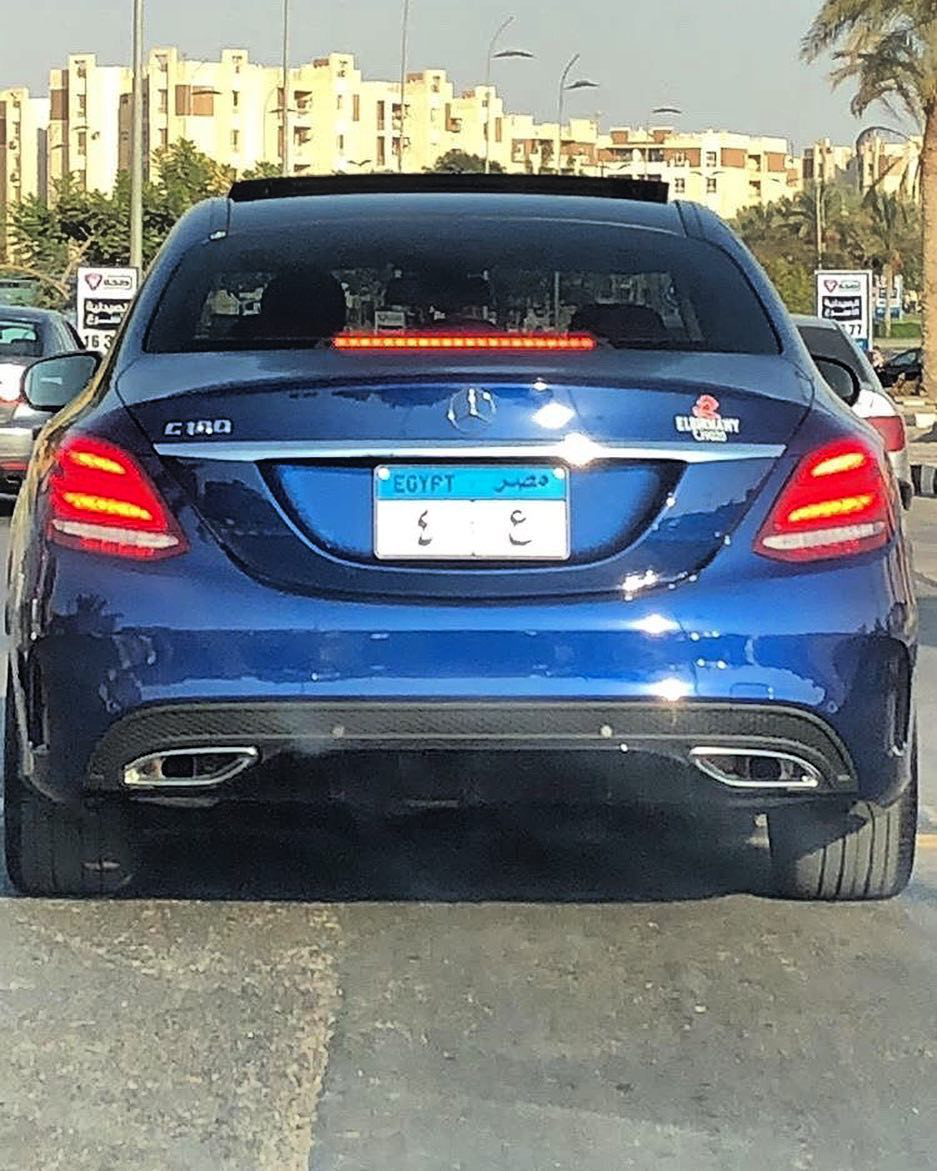

In [ ]:
fig = px.imshow(img)
fig.update_layout(width=800, height=800,margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure - image with bounding box')
fig.add_shape(type='rect',x0=xmn, x1=xmx, y0=ymn, y1=ymx, xref='x', yref='y',line_color='cyan')

# Read Data

In [ ]:
labels = df.iloc[:,1:].values
print(labels)
data = []
output = []


[[0.312778 0.708444 0.214444 0.087111]
 [0.412963 0.546296 0.138889 0.07037 ]
 [0.821296 0.702778 0.122222 0.07037 ]
 ...
 [0.418519 0.657778 0.174074 0.077037]
 [0.486111 0.489379 0.220588 0.116013]
 [0.488426 0.603704 0.184259 0.07963 ]]


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr =cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    bx,by,bw,bh = labels[ind]
    xmin,xmax,ymin,ymax=convert(bx,by,bw,bh)
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [ ]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
# Split the data into training and testing set using sklearn.
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=42)
x_train.shape,x_test.shape,x_val.shape,y_train.shape,y_test.shape,y_val.shape

((1502, 224, 224, 3),
 (418, 224, 224, 3),
 (167, 224, 224, 3),
 (1502, 4),
 (418, 4),
 (167, 4))

In [ ]:
#

#*Model* *Building*

In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [ ]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1218 (Conv2D)           (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1218 (Batc  (None, 111, 111, 32  96         ['conv2d_1218[0][0]']            
 hNormalization)                )                                                           

In [ ]:
tfb = TensorBoard('plate_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=180,validation_data=(x_val,y_val),callbacks=[tfb])

Epoch 1/180
151/151 [==============================] - 57s 263ms/step - loss: 0.0137 - accuracy: 0.7317 - val_loss: 0.0091 - val_accuracy: 0.7545
Epoch 2/180
151/151 [==============================] - 35s 233ms/step - loss: 0.0034 - accuracy: 0.8695 - val_loss: 0.0113 - val_accuracy: 0.8323
Epoch 3/180
151/151 [==============================] - 35s 234ms/step - loss: 0.0015 - accuracy: 0.9128 - val_loss: 0.0106 - val_accuracy: 0.8743
Epoch 4/180
151/151 [==============================] - 35s 234ms/step - loss: 9.1289e-04 - accuracy: 0.9427 - val_loss: 0.0089 - val_accuracy: 0.8862
Epoch 5/180
151/151 [==============================] - 35s 233ms/step - loss: 6.1191e-04 - accuracy: 0.9381 - val_loss: 0.0094 - val_accuracy: 0.8802
Epoch 6/180
151/151 [==============================] - 35s 233ms/step - loss: 5.4751e-04 - accuracy: 0.9607 - val_loss: 0.0074 - val_accuracy: 0.8563
Epoch 7/180
151/151 [==============================] - 35s 233ms/step - loss: 0.0010 - accuracy: 0.9234 - val_lo

In [ ]:
model.evaluate(x_test,y_test)

14/14 [==============================] - 2s 167ms/step - loss: 0.0020 - accuracy: 0.9569


[0.0020141147542744875, 0.9569377899169922]

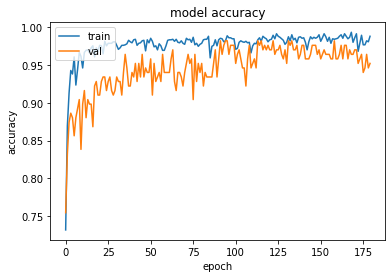

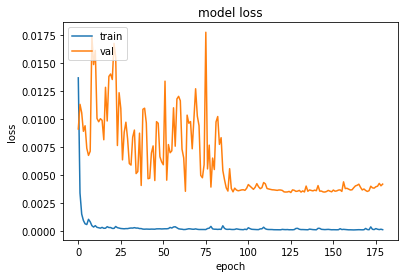

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('./plate_detection.h5')

In [ ]:
model.save("/content/drive/MyDrive/plate_detection.h5")

In [ ]:
# Load model
model = tf.keras.models.load_model('./plate_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [ ]:
path = '/content/1.jpg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 955
Width of the image = 1300



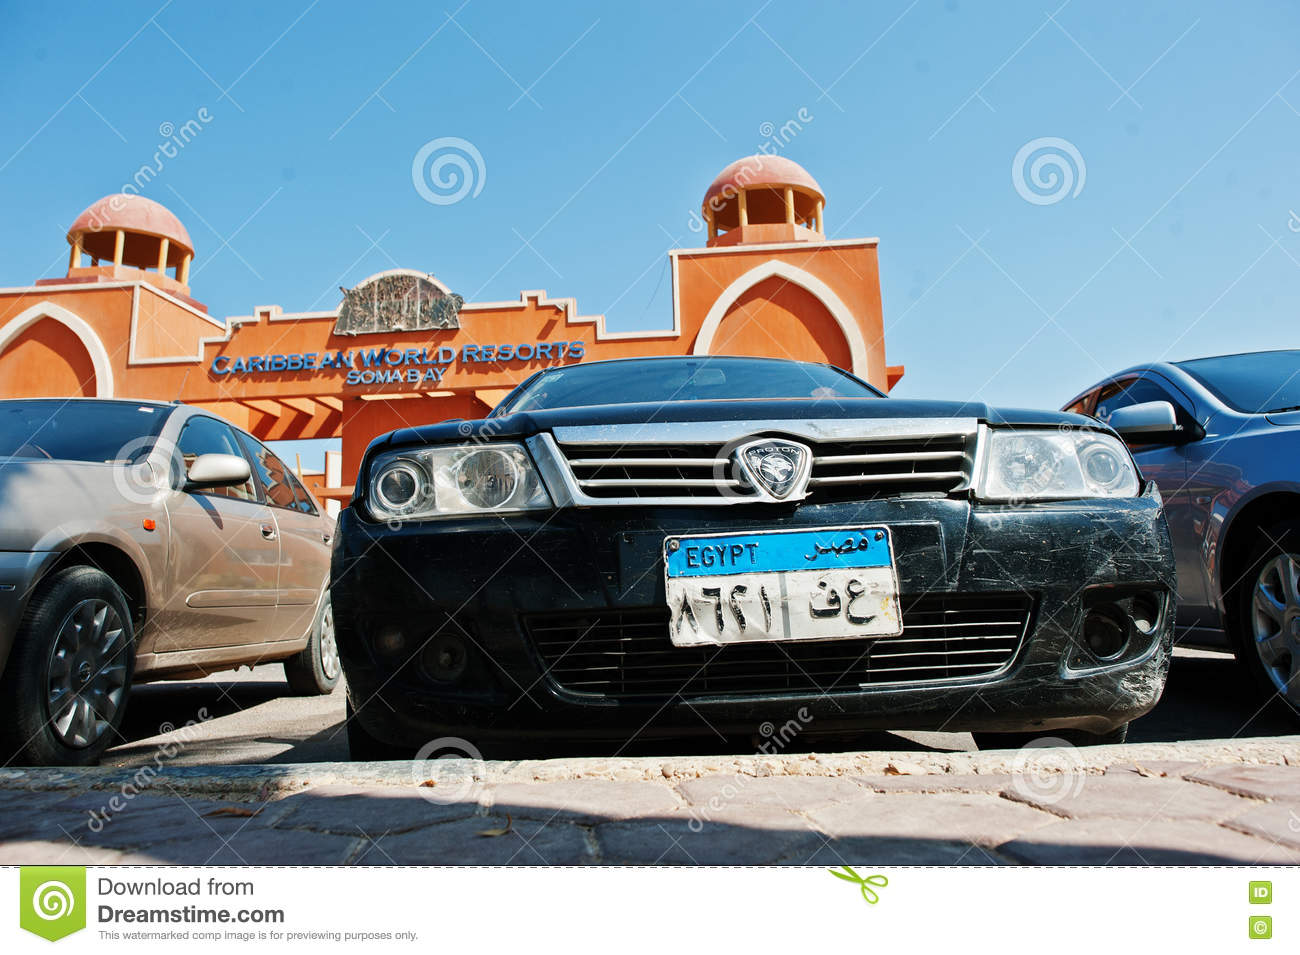

In [ ]:
fig = px.imshow(image)
fig.update_layout(width=500, height=600,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure - TEST Image')

In [ ]:
image_arr_224.shape

(224, 224, 3)

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [ ]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 0s 54ms/step


array([[0.50201035, 0.70633864, 0.5403475 , 0.67442405]], dtype=float32)

In [ ]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[652.6134491 , 918.24023724, 516.03187829, 644.07496989]])

In [ ]:
coords = coords.astype(np.int32)
coords

array([[652, 918, 516, 644]], dtype=int32)

In [ ]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(652, 516) (918, 644)



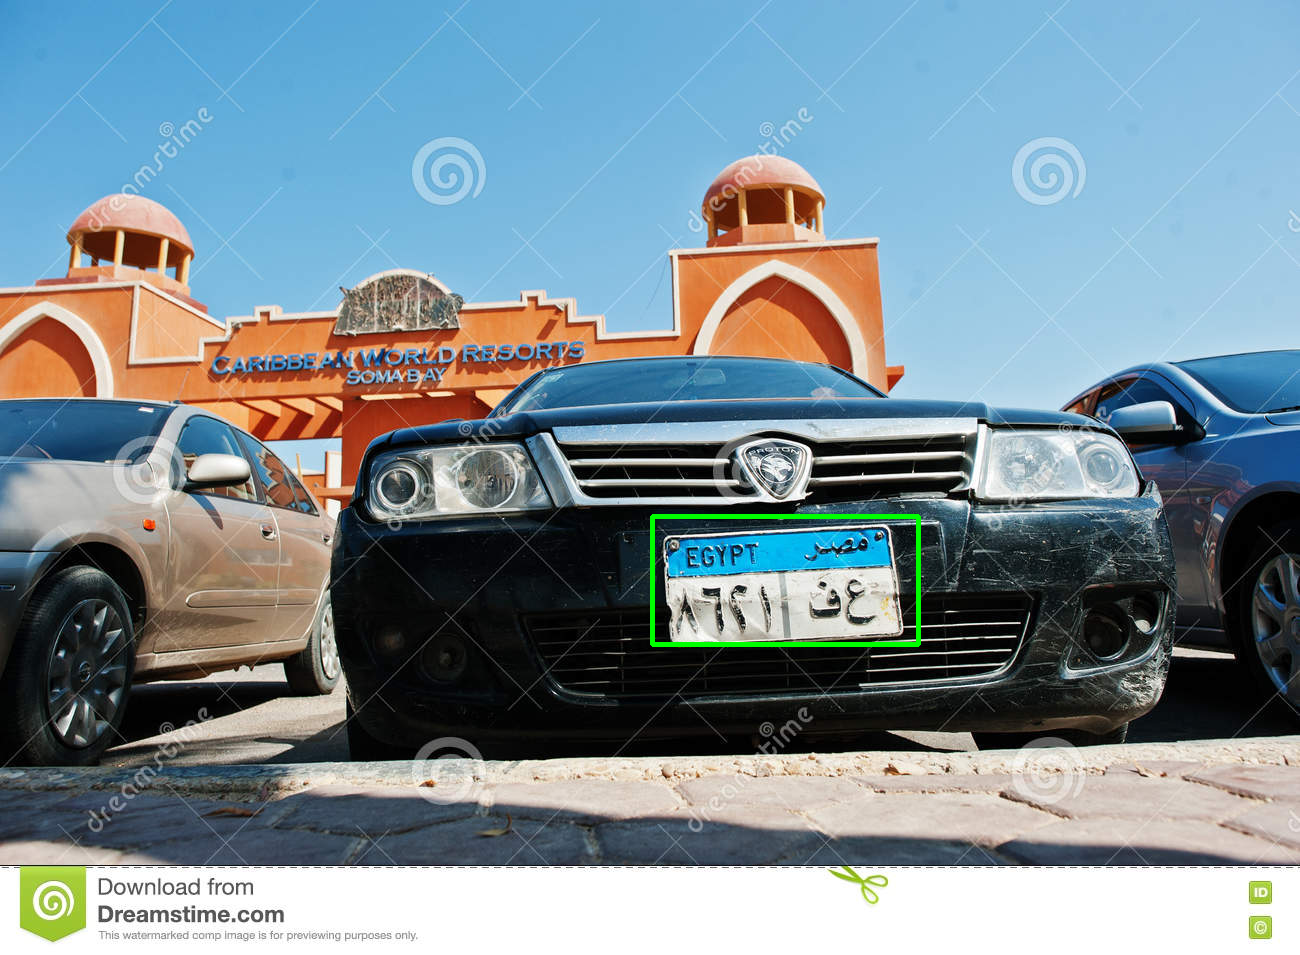

In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=1000, height=1000, margin=dict(l=10, r=10, b=10, t=10))

In [ ]:
# Create pipeline
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

1/1 [==============================] - 0s 52ms/step
(167, 232) (211, 255)



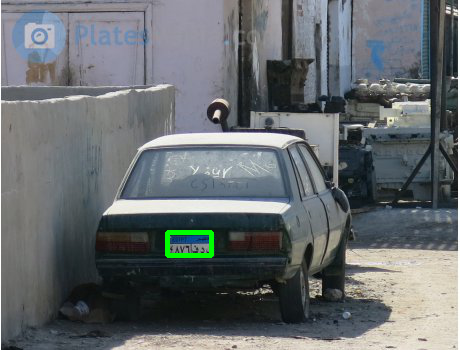

In [ ]:
path = '/content/6.jpg'
image, cods = object_detection(path)
fig = px.imshow(image)
fig.update_layout(width=500, height=600, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 [==============================] - 0s 83ms/step
(143, 219) (199, 249)



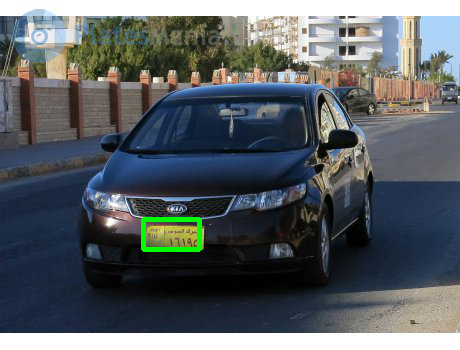

In [ ]:
path = '/content/7.jpg'
image, cods = object_detection(path)
fig = px.imshow(image)
fig.update_layout(width=500, height=600, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 [==============================] - 0s 114ms/step
(652, 516) (918, 644)



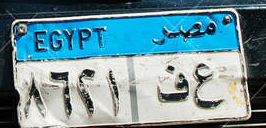

In [ ]:
path='/content/1.jpg'
image, cods = object_detection(path)
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=500, height=1000, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure Cropped image')